# Tire Swing Problem
<bk>
Meagan Rittmanic and Corinne Wilklow
<bk>
9 December 2018

In [88]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import numpy
import numpy as np

# import LaTeX
from sympy import *

from sympy.printing import latex

def show(expr, show_latex=False):
    """Display a SymPy expression.
    
    expr: SymPy expression
    show_latex: boolean
    """
    if show_latex:
        print(latex(expr))
    return expr

init_printing() 

#import pictures
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


print('done')

done


## What is the max force that someone can push a child on a tire swing before the child falls? 

We modeled the system of a single child on a tire swing to determine the max force that someone can push the tire swing without the child falling. To do this we gathered average weight data and average grip strength data for children ages 6 to 12. 

### Model

First, some equations that will be important to the implementation of our model:

$\frac{d\theta}{dt} = \omega $  Where $\theta$ is angular position, and $\omega$ is angular velocity.
<bk>
$\frac{d\omega}{dt} = \alpha = \frac{\omega^2}{2\theta} = \frac{d^2\theta}{dt^2} = \frac{\tau}{I_{system}}$ Where $\tau$ is the torque and $I_{system}$ is the rotational inertia of the system.
<bk>
$F_{hold} + F_{sf} = \frac{mv^2}{r} $ Where $F_{hold}$ is the force that the child holds on with, $F_{sf}$ is the force of static friction acting on the child and $\frac{mv^2}{r}$ is the centripetal force pulling the child off the tire swing.

Second, a schematic of our model:

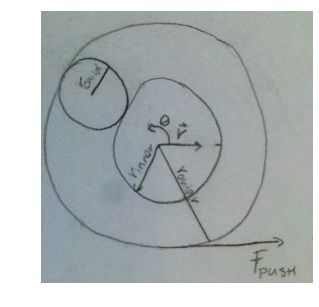

In [89]:
plt.figure(figsize=(5,5))

myImage = mpimg.imread("schematic.JPG")

myImage = plt.imshow(myImage)

plt.axis('off')

plt.show() 

To implement our model, we started by importing the various units that we needed.

In [90]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
rad = UNITS.radian

<Unit('radian')>

We created a params object to hold the parameters that we would need for our project, including units. Everything that was in units of Newtons we converted to kilograms * meters/second^2  because the library we are using has trouble with that conversion.
<bk>
Our data on the grip strength of children of various ages from [this study](https://ajot.aota.org/article.aspx?articleid=1884114), and the average mass of children of different ages comes from [here](https://www.disabled-world.com/calculators-charts/height-weight-teens.php). We found the coefficient of friction between the clothing of the child (fabric) and the tire (rubber) from [this study](http://www.ircobi.org/wordpress/downloads/irc16-asia/pdf-files/48.pdf), which claimed that the coefficient between fabric and rubber was approximately 1. We found that the mass of the tire swing was about 120 lbs, or 54.54 kg, from [here](http://www.energyjustice.net/files/tires/files/scrapchn.html). Our tire size data came from [this website](https://www.tirerack.com/tires/tiretech/techpage.jsp?techid=53), where we chose a one meter, because it is handy for physics calculations, and also because it is within the higher part of the range. We assumed the radius of the child to be a little less than our radius, so we estimated it to be about 0.09 m. We chose the initial duration of the push to be one full rotation of the tire swing.
<bk>
For our first run of our model, we also decided to use the average grip strength and mass of a 6-year-old child.


In [91]:
params = Params(child_strength = 132 * kg*m/(s**2),
                mass_child = 16 * kg,
                mu_friction = 1,
                g = 9.81 * m/(s**2),
                mass_tire_swing = 54.54 * kg, 
                radius_child = .09 * m,
                duration_push = np.pi*2 * rad,
                radius_inside_tire = 0.5 * m,
                radius_outside_tire = 1 *m,
                t_end = 30 * s)

,values
child_strength,132.0 kilogram * meter / second ** 2
mass_child,16 kilogram
mu_friction,1
g,9.81 meter / second ** 2
mass_tire_swing,54.54 kilogram
radius_child,0.09 meter
duration_push,6.283185307179586 radian
radius_inside_tire,0.5 meter
radius_outside_tire,1 meter
t_end,30 second


We then created our system, creating a state with $\theta$, or the angular position, and $\omega$, or angular velocity. We also calculated the force of friction based on the mass of our child, the value of the acceleration due to gravity, and the coefficient due to friction between our child and the tire. We took the average of the inner and outer radii of our tire to be the radius to the center of mass of our child from the center of rotation, the center of the tire swing. We also added the force of the starting push.

In [92]:
def make_system(theta, omega, F_push, params):
    """Make a system object.
    
    params: Params object with angle, velocity, mu, 
             duration, g, masses, radii, and t_end
               
    returns: System object
    """
    unpack(params)
    
    init = State (theta=theta * rad, omega=omega * rad/s)
    F_friction = mass_child * g * mu_friction
    radius_to_child = (radius_inside_tire + radius_outside_tire)/2
    F_push = F_push * kg *m/(s**2)
    
    return System(params, F_friction=F_friction, radius_to_child = radius_to_child, F_push = F_push, init=init)

In [93]:
system = make_system(0, 0, 20, params)

,values
child_strength,132.0 kilogram * meter / second ** 2
mass_child,16 kilogram
mu_friction,1
g,9.81 meter / second ** 2
mass_tire_swing,54.54 kilogram
radius_child,0.09 meter
duration_push,6.283185307179586 radian
radius_inside_tire,0.5 meter
radius_outside_tire,1 meter
t_end,30 second


Next, we created a slope function, finding the change in theta and change in omega throughout the duration of the push.  In order to find alpha, our change in angular velocity, we used the equation $I = \tau\alpha$, with $I$ being rotational inertia of the system, $\tau$ being torque, and $\alpha$ being the change in rotational velocity. We found the rotational inertia of the tire-swing-child system by finding the sum of the rotational inertia of the tire swing and the rotational inertia of the child (which we approximated to be a cylinder) using the parallel axis theorem when finding the rotational inertia of the child because the child was not rotating about its center of mass.

In [94]:
def slope_func(state, t, system):
    '''Make a slope function that 
        takes into account the rotational inertia of both objects, 
        applies a torque, 
        and returns the change in theta and change in omega'''
    
    theta, omega = state
    unpack (system)
    
    Torque = radius_outside_tire * F_push
    
    I_tire = .5*mass_tire_swing*(radius_inside_tire**2 + radius_outside_tire**2)
    I_child = .5*mass_child*radius_child**2 + mass_child * (radius_to_child)**2
    I_system = I_tire + I_child
    
    alpha = Torque / I_system
    
    d_theta_dt = omega
    d_omega_dt = alpha
    
    return d_theta_dt, d_omega_dt

We made an event function to stop the push when the desired duration of the push was reached. For our first run, this duration was one full rotation.

In [95]:
def event_func(state, t, system):
    
    '''Make an event function that stops the ODE solver from running when the push ends'''
    
    theta, omega = state
    unpack (system)
    
    return theta - duration_push

We created an error function to find the force of the push that would make the force of static friction between the child’s clothing and the tire added to the strength of the child holding onto the tire swing equal to $\frac{mv^2}{r}$, with $m$ being the mass of the child, $v$ being the linear velocity of the child, and $r$ being the radius between the center of rotation and the child. We used this equation because it is the version of Newton’s second law that can be applied to rotational kinematics, in which a force changes the direction of linear velocity as opposed to the magnitude of linear velocity. For each run of the error function, we made a system with the given force of the push, and then we ran our slope function through our ODE solver, returning the final value of rotational velocity. We then multiplied that value by the radius to the child to find our final linear velocity. Finally, we found the maximum strength that the child can exert to keep themselves on the swing by multiplying their grip strength by two hands. We chose to assume that their legs on the inside of the tire swing do not hold them on the swing because if the child’s hands slip, they have essentially fallen off the swing for our purposes.
<bk>
We ran our error function with a test force of 5 Newtons, printing $F_{push}$ and the final difference for each run of the function.


In [96]:
def error_func(F_push, system):
    
    '''Define an error func that outputs the difference between the combined grip strength and frictional force 
    holding child to the tire swing and total force acting on them'''
    
    system = make_system(0, 0, F_push, params)
    results, details = run_ode_solver(system, slope_func, 
                                  events=event_func)
    omega_final = get_last_value(results.omega)
    
    v_final = omega_final*radius_to_child / s
    
    print (F_push)
    print (system.child_strength + system.F_friction - ( system.mass_child * v_final**2)/radius_to_child)
    
    return system.child_strength*2 + system.F_friction - ( system.mass_child * v_final**2)/radius_to_child

In [97]:
error_func(5, system)

5
271.4874148339358 kilogram * meter / second ** 2


<Quantity(403.4874148339358, 'kilogram * meter / second ** 2')>

We ran fsolve using our error function, finding that, for a 6-year-old child and a push that lasts one whole rotation, the maximum average force one can push the swing at is 120.5 Newtons.

In [98]:
fsolve(error_func, 5, system) * N

5
271.4874148339358 kilogram * meter / second ** 2
[5]
271.4874148339358 kilogram * meter / second ** 2
[5.]
271.4874148339358 kilogram * meter / second ** 2
[5.]
271.4874148339358 kilogram * meter / second ** 2
[5.00000007]
271.4874145735741 kilogram * meter / second ** 2
[120.46303289]
-132.00012031357875 kilogram * meter / second ** 2
[120.46299846]
-131.99999999999994 kilogram * meter / second ** 2


<Quantity([120.46299846], 'newton')>

In order to further iterate on our system, we imported a Dataframe with data referring to child average mass and grip strength with respect to age.

In [99]:
child_data = pd.read_csv('child_data.csv', index_col = 0)

,Mass,Grip
Age,,
6,15.873,132.165
8,25.737,165.985
10,31.973,219.385
12,40.703,246.975


We added units to the data, with kilograms as the unit of mass and Newtons (or kilograms * meters / second^2) as the unit of force.

In [100]:
child_data.Mass.units = kg
child_data.Grip.units = kg * m / s**2

We created a second error function identical to our first except that it does not print the force of the push or the final difference.


In [101]:
def error_func_2(F_push, system):
    
    '''Define an error func that outputs the difference between the combined grip strength and frictional force 
    holding child to the tire swing and total force acting on them'''
    system = make_system(0, 0, F_push, params)
    
    results, details = run_ode_solver(system, slope_func, 
                                  events=event_func)
    omega_final = get_last_value(results.omega)
    
    v_final = omega_final*radius_to_child / s
    
    return system.child_strength*2 + system.F_friction - ( system.mass_child * v_final**2)/radius_to_child

In order to run through the values for each age, we created an array with the four different ages we had access to. In the for loop, we made a new params object that changed the parameters so they aligned with the mass and grip strength of that age of child. We then made a system and ran our fsolve function, finding the age and consequent maximum force for each age.

In [102]:
array = np.array([6, 8, 10, 12])
for Age in array:
    params = Params(params, child_strength = child_data.loc[Age]["Grip"] * kg*m/s**2, child_mass = child_data.loc[Age]["Mass"] * kg)
    system = make_system(0, 0, F_push, params)
    Force = fsolve(error_func_2, 300, system)
    print (Age, Force)

6 [120.55743211]
8 [139.91346883]
10 [170.47563207]
12 [186.26608307]


### Results
<bk>
We graphed our findings, modeling maximum force of push with respect to age for a push with the duration of one full rotation.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


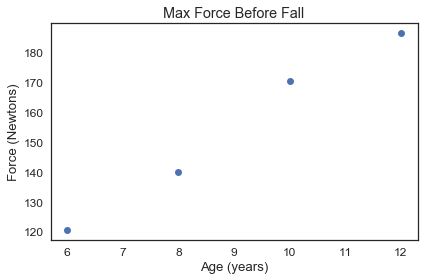

In [103]:
Age = array
print(type(Age))
Force = np.array([120.56, 139.91, 170.47, 186.27])
print(type(Force))
plt.plot(Age, Force, 'o')
decorate(xlabel = 'Age (years)',
        ylabel = 'Force (Newtons)',
        title = 'Max Force Before Fall')

We then graphed our findings with respect to mass of child so that people who had unusually large or small children for that age might be able to more accurately define which maximum force of push they should use.

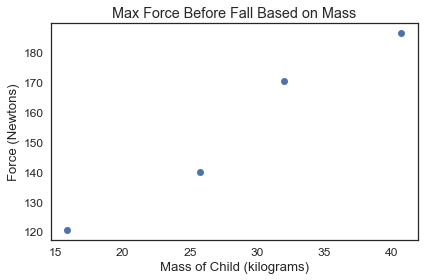

In [104]:
Mass = np.array([15.87301587, 25.73696145, 31.97278912, 40.70294785])
plt.plot(Mass, Force, 'o')
decorate (title = 'Max Force Before Fall Based on Mass',
         xlabel = 'Mass of Child (kilograms)',
         ylabel = 'Force (Newtons)')

We then assumed a different scenario, taking into account how someone might push in a single, quicker push as opposed to a push that lasted an entire rotation. We ran the simulation again with the push lasting only a quarter rotation, more of a single, quick push as opposed to a continuous push.

6 [482.22972845]
8 [559.65387532]
10 [681.90252826]
12 [745.06433228]


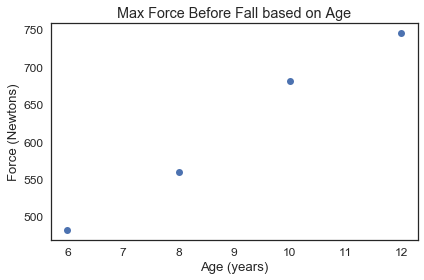

In [105]:
system.duration_push = np.pi/2
array = np.array([6, 8, 10, 12])
for Age in array:
    params = Params(params, child_strength = child_data.loc[Age]["Grip"] * kg*m/s**2, 
                    child_mass = child_data.loc[Age]["Mass"] * kg,
                   duration_push = np.pi/2 * rad)
    system = make_system(0, 0, F_push, params)
    Force = fsolve(error_func_2, 300, system)
    print (Age, Force)
Age = array
Force = np.array([482.23, 559.65, 681.90, 745.06])
plt.plot(Age, Force, 'o')
decorate(xlabel = 'Age (years)',
        ylabel = 'Force (Newtons)',
        title = 'Max Force Before Fall based on Age')    

We also graphed this data based on mass.

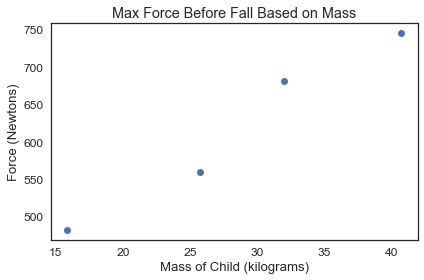

In [106]:
Mass = np.array([15.87301587, 25.73696145, 31.97278912, 40.70294785])
plt.plot(Mass, Force, 'o')
decorate (title = 'Max Force Before Fall Based on Mass',
         xlabel = 'Mass of Child (kilograms)',
         ylabel = 'Force (Newtons)')

### Interpretation
<bk>
To get our information about perspective in reference to various weights, we used these sources:
<bk>
[20 lbs](http://shailah.blogspot.com/2011/11/random-things-that-weigh-20-lbs.html)
<bk>
[30 lbs](https://2fluffy2long.wordpress.com/what-things-weigh-weight-loss-reference/)
<bk>
[Converting Newtons to Pounds](http://www.kylesconverter.com/force/newtons-to-pounds--force)
<bk>
[Lager weights](http://www.ewtaz.com/images/uploads/average-weight-furniture-2.pdf)
<bk>
In order to make this data more accessible, 120.56 Newtons is 27.1 pounds of force, 139.91 Newtons is 31.45 pounds of force, 170.48 Newtons is 38.33 pounds of force, and 186.27 Newtons is 41.88 pounds of force.
<bk>
To put that in perspective, 20 pounds is about the weight of a small to medium sized dog, a regular car tire, a kitchen aid mixer, or a one-year-old. 30 pounds is about the weight of an average toddler or a cinder block. 36 pounds is about the size of a microwave. For a full rotation, a fairly strong push might send a kid falling off.
<bk>
For the second run, 482.23 Newtons is 108.41 pounds, 559.65 Newtons is about 125.81 pounds of force, 681.9 Newtons is 153.3 pounds of force, and 745.06 Newtons is 167.5 pounds.
<bk>
To put that in perspective, 80 pounds is about the weight of a medium-sized TV, 100 pounds is about the weight of a toilet, 150 pounds is about the weight of a 3-cushion sofa. For this short of a push, it would be very difficult to push hard enough to get a kid to fall off.